In [318]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [319]:
from enum import Enum

In [320]:
class Point:
    def __init__(self):
        self.x = None
        self.y = None
        self.z = None

        self.id = None


In [321]:
class CLASSIFIED_STATUS(Enum):
    SUCCESS = 0
    UNCLASSIFIED = -1
    NOISE = -2
    FAILURE = -3

#class CLASSIFIED_STATUS:
#    def __init__(self):
#        self.SUCCESS = 0
#        self.UNCLASSIFIED = -1
#        self.NOISE = -2
#        self.FAILURE = -3

class POINT_STATUS(Enum):
    CORE_POINT      = 1
    BORDER_POINT    = 2
    OTHER           = 0


In [335]:
class DBSCAN:
    def __init__(self, points, min_points_th, max_points_th, eps):
        self.__min_points_th    = min_points_th
        self.__epsiron          = eps
        self.__points           = points
        self.__points_size      = len(points)

        self.__max_points_th    = max_points_th

        self.__cluster_size     = None

        
    
    def Run(self):
        cluster_id = 1

        for point in self.__points:
            if point.cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED:
                if self.ExpandCluster(point, cluster_id) != CLASSIFIED_STATUS.FAILURE:
                    cluster_id = cluster_id + 1
        self.__cluster_size = cluster_id
        return(cluster_id)

    def CalcurateCluster(self, point):
        cluster_index = []
        index = 0
        for p in self.__points:
            if self.CalcurateDistance(point, p) <= self.__epsiron:
                cluster_index.append(index)
                
                # Max Cluster Size
                #if len(cluster_index) >= self.__max_points_th:
                #    break
            
            index = index + 1
            
        return(cluster_index)

    def ExpandCluster(self, point, cluster_id):
        seeds = self.CalcurateCluster(point)
        #print(seeds)
        if len(seeds) < self.__min_points_th:
            #point.cluster_id = 100
            point.cluster_id = CLASSIFIED_STATUS.NOISE
            return(CLASSIFIED_STATUS.FAILURE)

        index = 0
        index_core_point = 0

        for seed in seeds:
            self.__points[seed].cluster_id = cluster_id
            if self.CheckSamePoint(self.__points[seed], point) == True:
                index_core_point = index
                #print("Core point:", index_core_point, " list size:", len(seeds))
            index = index + 1

        if index_core_point != (len(seeds)-1):
            seeds[index_core_point] = seeds.pop(-1)

        for i in range(len(seeds)):
            # Range Search
            cluster_neighbors = self.CalcurateCluster(self.__points[seeds[i]])

            if len(cluster_neighbors) >= self.__min_points_th:
                for neighbor in cluster_neighbors:            
                    #print(len(seeds))
                    
                    # Max Cluster Size
                    #if len(seeds) >= self.__max_points_th:
                    #    return(CLASSIFIED_STATUS.SUCCESS)
                    #    break

                    if self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED \
                        or self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.NOISE:
                        if self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED:
                            seeds.append(neighbor)
                        self.__points[neighbor].cluster_id = cluster_id

        return(CLASSIFIED_STATUS.SUCCESS)
        



    def CalcurateDistance(self, point_core, point_target):
        dx = point_target.x - point_core.x
        dy = point_target.y - point_core.y
        dz = point_target.z - point_core.z

        distance = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
        return(distance)

    def CheckSamePoint(self, point1, point2):
        distance = self.CalcurateDistance(point1, point2)
        if distance < 0.01:
            return(True)
        else:
            return(False)

    def CalcurateDoubleDistance(self, point_core, point_target):
        dx = point_target.x - point_core.x
        dy = point_target.y - point_core.y
        dz = point_target.z - point_core.z

        double_distance = dx ** 2 + dy ** 2 + dz ** 2
        return(double_distance)

    def GetTotalPointSize(self):
        return(self.__point_size)

    def GetMinimumClusterSize(self):
        return(self.__min_points_th)
    
    def GetEpsilon(self):
        return(self.__epsiron)

    def GetPoints(self):
        return(self.__points)

    def GetClusterSize(self):
        return(self.__cluster_size)



In [336]:
import random


In [337]:
min_points_th = 2
max_points_th = 30
eps = 3
points_num = 1000

max_x = 50.0
max_y = 50.0

In [338]:
points = [Point() for i in range(points_num)]
for i in range(len(points)):
    points[i].x = random.uniform(0,max_x)
    points[i].y = random.uniform(0,max_y)
    points[i].z = 0
    points[i].cluster_id = CLASSIFIED_STATUS.UNCLASSIFIED

In [339]:
db = DBSCAN( points, min_points_th, max_points_th, eps)

In [340]:
db.Run()

65

In [341]:
points = db.GetPoints()

In [342]:
#for p in points:
#    print("(", p.x, ",\t", p.y, ",\t", p.z, ") : \t", p.cluster_id)

In [343]:
import matplotlib.cm as cm
import matplotlib.patches as patches

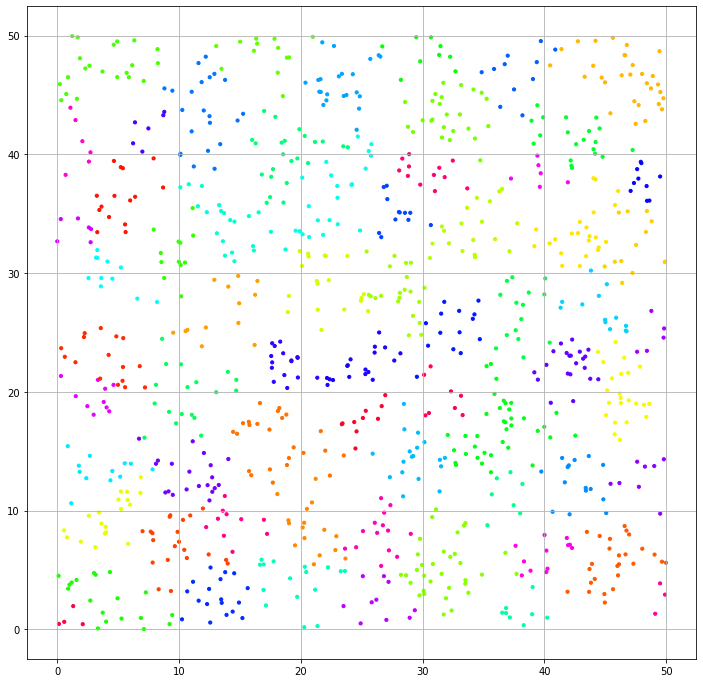

In [344]:

fig, ax = plt.subplots(figsize=[12,12])
x = []
y = []
cluster = []

noise_x = []
noise_y = []
cluster_size = db.GetClusterSize()
for p in points:
    if p.cluster_id != CLASSIFIED_STATUS.NOISE:
        x.append(p.x)
        y.append(p.y)
        cluster.append(p.cluster_id / cluster_size)
    else:
        noise_x.append(p.x)
        noise_y.append(p.y)
        c = patches.Circle(xy=(p.x,p.y), radius=eps, fc="None", ec="black")
        ax.add_patch(c)
        #p.cluster_id = -2
cluster_size

ax.scatter(x=x, y=y, color = cm.hsv(cluster), s = 10)
ax.scatter(x=noise_x, y=noise_y, color="black", s= 15)
ax.grid()

In [345]:
def SavePoints(filedir, points, partition = ","):
    with open(filedir, "w") as f:
        f.write(str(len(points))+"\n")
        for point in points:
            cluster_id = 0
            if point.cluster_id != CLASSIFIED_STATUS.NOISE:
                cluster_id = point.cluster_id
            else:
                cluster_id = -2
            str_data = str(point.x) + partition + str(point.y) + partition + str(point.z) + partition + str(cluster_id) + "\n"
            f.write(str_data)

In [346]:
SavePoints("./sample_pcl.xyz", points, partition=" ")